# Toy Example

## Settings

\begin{align}
    S_{0}&\sim Bernoulli(0.5)\\
    M_{t}&\sim Bernoulli(expit(1.0-1.5S_{t}+2.5A_{t}))\\
    R_{t}&\sim Bernoulli(expit(1.0+2S_{t}-1A_{t}-2.5M_{t}))\\
    S_{t+1}&\sim Bernoulli(expit(.5+3.0S_{t}-2.5A_{t}-.5M_{t}))\\
    \pi_{b}&\sim Bernoulli(expit(1.0-2.0S{t}))\\
    \pi_{e}&\sim Bernoulli(expit(1.5+1.0S{t}))\\
    a_0&=0
\end{align}

In [2]:
import pickle
import numpy as np
import pandas as pd

### MC true $P_{\pi_e}(S_t)$

<AxesSubplot:>

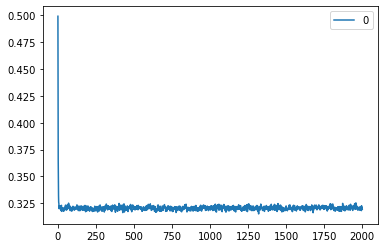

In [161]:
with open("true_eta.txt", 'rb') as p:
    x = pickle.load(p)
S = [rec[3] for rec in x[500][2000]]
pd.DataFrame(np.mean(np.vstack(S),0)).plot()

In [162]:
np.mean(np.vstack(S))

0.3207236581709146

<AxesSubplot:>

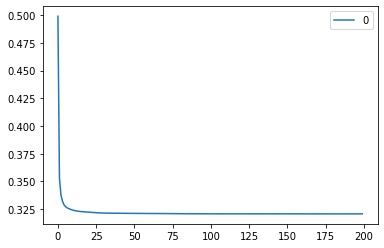

In [163]:
burn_in = 500
S = [rec[3] for rec in x[500][2000]]
mean = []
for n in range(1,2000,10):
    mean.append(np.mean(np.mean(np.vstack(S),0)[:n]))
pd.DataFrame(mean).plot()

In [164]:
mean[-1]

0.32072503264691105

### MC true $P_{a_{0}}(S_t)$


<AxesSubplot:>

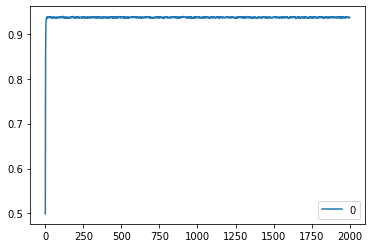

In [39]:
with open("true_eta_a0.txt", 'rb') as p:
    x = pickle.load(p)
S = [rec[3] for rec in x[500][2000]]
pd.DataFrame(np.mean(np.vstack(S),0)).plot()

In [40]:
np.mean(np.vstack(S))

0.9361090004997501

<AxesSubplot:>

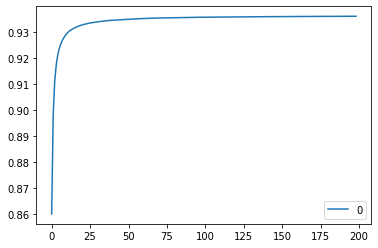

In [41]:
burn_in = 500
S = [rec[3] for rec in x[500][2000]]
mean = []
for n in range(10,2000,10):
    mean.append(np.mean(np.mean(np.vstack(S),0)[:n]))
pd.DataFrame(mean).plot()

### MC true $P_{G}(S_t)$


<AxesSubplot:>

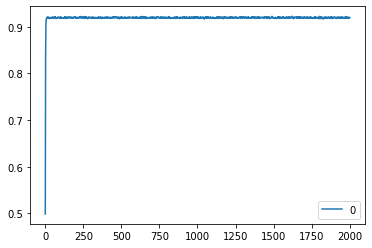

In [4]:
with open("true_eta_G.txt", 'rb') as p:
    x = pickle.load(p)
S = [rec[3] for rec in x[500][2000]]
pd.DataFrame(np.mean(np.vstack(S),0)).plot()

In [5]:
np.mean(np.vstack(S))

0.9191004897551226

<AxesSubplot:>

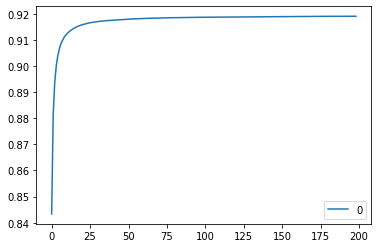

In [6]:
burn_in = 500
S = [rec[3] for rec in x[500][2000]]
mean = []
for n in range(10,2000,10):
    mean.append(np.mean(np.mean(np.vstack(S),0)[:n]))
pd.DataFrame(mean).plot()

### MC true $P_{b}(S_t)$

<AxesSubplot:>

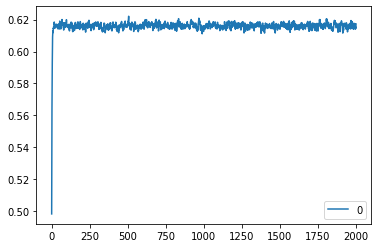

In [169]:
with open("true_pb_S.txt", 'rb') as p:
    x = pickle.load(p)
S = [rec[2] for rec in x[500][2000]]
pd.DataFrame(np.mean(np.vstack(S),0)).plot()

In [170]:
np.mean(np.vstack(S))

0.6158938480759618

<AxesSubplot:>

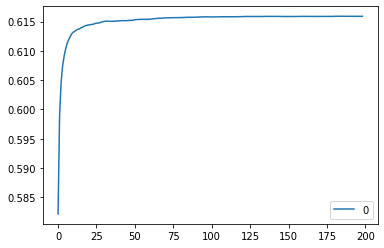

In [171]:
burn_in = 500
S = [rec[2] for rec in x[500][2000]]
mean = []
for n in range(10,2000,10):
    mean.append(np.mean(np.mean(np.vstack(S),0)[:n]))
pd.DataFrame(mean).plot()

In [172]:
mean[-1]

0.6158940552763817

In [181]:
0.9361090004997501/0.6158938480759618

1.5199193877713393

### Bellman:

\begin{align}
    E^{\pi}[R_{t}-\eta^{\pi}+V(S_{t+1})|S_{t}=s, A_{t}=a, M_{t}=m] = Q^{\pi}(S_{t},A_{t}, M_{t})
\end{align}

\begin{align}
    argmin_{Q}\sum_{i,t}^{\pi}[R_{t}-\eta^{\pi}+V(S_{t+1})-Q^{\pi}(S_{t},A_{t}, M_{T})]
\end{align}
,where $V(S_{t+1}) = E_{A,M}(Q^{\pi}(S_{t+1},A_{t+1}, M_{T+1}))$

Backdoor Adjustment:
\begin{align}
V(S_{t+1}) = \sum_{a,m} \pi(a|S_{t+1}) Q^{\pi}(m,a,S_{t+1})p(m|a,S_{t+1})
\end{align}


## True Q & True etas

In [1]:
def target_policy(state, action = None, matrix_based = False):
    if matrix_based:
        state1 = np.copy(state).flatten()
        pa = expit(1.5 + 1.0 * state1)
        if action is not None:
            action1 = np.copy(action).flatten()
            pa = pa * action1 + (1-pa) * (1-action1)
    else:
        pa = 1.5 + 1.0 * np.sum(state)
        pa = expit(pa)
        pa = np.random.binomial(n=1, p=pa, size=1)
    return pa
    
def toy_sa2mediator_model(state, action, matrix_based = False):
    if matrix_based:
        state1 = np.copy(state).flatten()
        action1 = np.copy(action).flatten()
        pm =  1.0 - 1.5 * state1 + 2.5 * action1
        pm = expit(pm)
    else:
        pm = 1.0 - 1.5 * state + 2.5 * action
        pm = expit(pm)
        pm = np.random.binomial(n=1, p=pm, size=1)
    return pm

def pmlearner(state, action, mediator):
    pm_one = toy_sa2mediator_model(state, action=action, matrix_based = True).flatten() 
    pm = mediator * pm_one + (1 - mediator) * (1 - pm_one)
    return pm

def control_policy(state = None, action=None, get_a = False, matrix_based=False):
    # fixed policy with fixed action 0
    if get_a:
        action_value = 0
        
    elif matrix_based:
        action1 = np.copy(action).flatten()
        action_value = 1 - action1 ###for a0 = 0 only
        
    else:
        if action is None:
            action_value = 0 
        else:
            if action == 0:
                action_value = 1
            else:
                action_value = 0
    return action_value

def toy_sam2reward_model(state, action, mediator, random = None, matrix_based = False):
        if matrix_based:
            #print("matrix")
            state1 = np.copy(state).flatten()
            action1 = np.copy(action).flatten()
            mediator1 = np.copy(mediator).flatten()
            rmean = 1.0 + 2 * state1 - 1 * action1 -  2.5 * mediator1
            #rmean = 1.0 * np.ones(shape = state1.shape[0])
            rmean = expit(rmean)
            if random is None:
                rmean *= 10
                reward = rmean
            else:
                print("wrong")
        else:
            rmean = 1.0 + 2 * state - 1 * action -  2.5 * mediator
            #rmean = 1.0
            rmean = expit(rmean)
            if random:
                reward = np.random.binomial(n=1, p=rmean, size=1) * 10
            else:
                rmean *= 10
                reward = rmean
        return reward

In [2]:
###true without estimating etas
from tqdm import tqdm
import pickle
import numpy as np
from scipy.special import expit
from multiprocessing import Pool
import Policy as policy
import Simulator as Simulator
import pandas as pd
from qLearner_MC import Qlearner as Qlearner_MC
def learnQ(Qlearner, simulator, traj,target_policy, control_policy, toy_sam2reward_model, true_etas=None):
    q1 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q1", true_etas=true_etas)
    b_hat1 = q1.fit()
    
    q2 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q2", true_etas=true_etas)
    b_hat2 = q2.fit()
    
    q3 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q3",true_etas=true_etas)
    b_hat3 = q3.fit()
    
    #traj1 = simulator.sample_target_policy_trajectory(num_trajectory=num_trajectory, num_time=num_time,
    #                                                 seed=seed, policy = "control", burn_in=False, return_trajectory=True)
    #traj1 = simulator.trajectory2iid(trajectory = traj1)
    
    q4 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q4",true_etas=true_etas)
    b_hat4 = q4.fit()
    
    q5 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q5",true_etas=true_etas)
    b_hat5 = q5.fit()
    out = {'b_hat1':b_hat1, 'b_hat2':b_hat2, 'b_hat3':b_hat3,'b_hat4':b_hat4,'b_hat5':b_hat5, 'q1':q1, 'q2':q2, 'q3':q3,'q4':q4,'q5':q5}
    return out

simulator = Simulator.Simulator(dim_state=1, model_type='toy')
traj = simulator.sample_trajectory(num_trajectory=200, num_time=200,
                                                     seed=10, burn_in=False, return_trajectory=True)
traj = simulator.trajectory2iid(trajectory = traj)

out1 = learnQ(Qlearner_MC, simulator, traj, target_policy, control_policy, toy_sam2reward_model)
#out2 = learnQ(Qlearner2, target_policy, control_policy, toy_sam2reward_model)

out = []
for b in ['b_hat1','b_hat2','b_hat3','b_hat4', 'b_hat5']:
    out.append(out1[b])

In [3]:
out = pd.DataFrame(out,index = ['Q1','Q2','Q3','Q4','Q5'])
out

,0,1,2,3,4,5,6,7
Q1,4.546846,-5.680322,-6.306302,2.224551,1.124411,-10.211971,-3.535179,2.397011
Q2,5.362853,-4.549023,-6.593262,3.196803,1.897973,-10.427154,-1.085992,3.673697
Q3,8.448072,-5.012505,-1.219712,6.061331,8.267657,-5.444225,4.979667,4.896161
Q4,8.112468,-4.527494,-1.101693,5.956669,7.949510,-4.917440,4.979667,7.878408
Q5,5.262259,-6.714231,-6.557886,2.447661,1.802611,-11.334928,-3.535179,7.963093


In [7]:
out.iloc[3,:].to_numpy()

array([ 8.11246785, -4.527494  , -1.10169265,  5.95666873,  7.94951035,
       -4.91744047,  4.97966689,  7.87840782])

## True DE/ME/SE

In [9]:
    true_eta_pi = 2.39701065
    true_eta_pi_a0 = 3.67369661
    true_eta_pi_a0star = 4.89616138
    true_eta_G = 7.87840782
    true_eta_a0 = 7.96309271
    IDE = true_eta_pi - true_eta_pi_a0
    IME = true_eta_pi_a0 - true_eta_pi_a0star
    DDE = true_eta_pi_a0star - true_eta_G
    DME = true_eta_G - true_eta_a0
    IDE,IME,DDE,DME

(-1.27668596, -1.2224647699999998, -2.98224644, -0.08468489000000012)

## Robustness

In [1]:
import pickle
with open("robust_final.txt", 'rb') as p:
    Error = pickle.load(p)

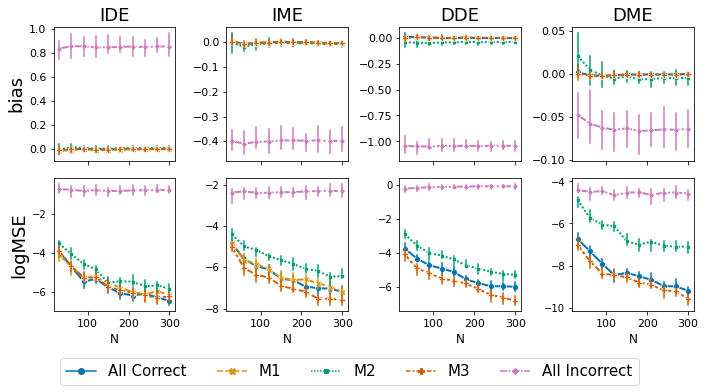

IDE_error  IME_error  DDE_error  DME_error   IDE_MSE  \
N     correct_model                                                         
30.0  All Correct    -0.014312   0.005019   0.008635   0.002037 -3.940861   
      All Incorrect   0.835484  -0.399247  -1.042609  -0.047252 -0.744863   
      M1             -0.018500   0.000826        NaN        NaN -4.090967   
      M2             -0.004015  -0.003352  -0.044317   0.021239 -3.518698   
      M3             -0.008025   0.001833  -0.005742   0.000591 -3.910716   
60.0  All Correct     0.000171  -0.009343   0.003449  -0.001260 -4.705272   
      All Incorrect   0.857027  -0.409228  -1.046604  -0.057242 -0.764061   
      M1             -0.005078  -0.011460        NaN        NaN -4.701670   
      M2              0.017142  -0.019052  -0.051128   0.005149 -4.072374   
      M3             -0.001638  -0.007108   0.002038  -0.001675 -4.677642   
90.0  All Correct     0.000683  -0.003031  -0.000700  -0.002173 -5.462707   
      All Incorrect   0.854693  -0.402053  -1.048433  -0.062011 -0.836229   
      M1             -0.002717  -0.007031        NaN        NaN -5.248701   
      M2              0.010126  -0.007493  -0.052012  -0.001628 -4.559895   
      M3             -0.000690  -0.002236  -0.001866  -0.001675 -5.269317   
120.0 All Correct    -0.002458  -0.002016  -0.004118  -0.001193 -5.336823   
      All Incorrect   0.846506  -0.400585  -1.042065  -0.064545 -0.787557   
      M1             -0.006704  -0.005402        NaN        NaN -5.238462   
      M2              0.004305  -0.005681  -0.047165  -0.005249 -4.844538   
      M3             -0.005971  -0.001905  -0.000644  -0.001504 -5.250931   
150.0 All Correct    -0.003252   0.001566  -0.006888  -0.000338 -5.767653   
      All Incorrect   0.846001  -0.395740  -1.045069  -0.062724 -0.834039   
      M1             -0.006404  -0.001755        NaN        NaN -5.559091   
      M2              0.003158  -0.002675  -0.047368  -0.002543 -5.534923   
      M3             -0.005222   0.000604  -0.004174  -0.000567 -5.730843   
180.0 All Correct    -0.002295  -0.000291  -0.000430  -0.000481 -6.062159   
      All Incorrect   0.850943  -0.396527  -1.040641  -0.065893 -0.832716   
      M1             -0.004196  -0.004201        NaN        NaN -5.775315   
      M2              0.006579  -0.004920  -0.039594  -0.005960 -5.446496   
      M3             -0.001588  -0.000848  -0.000341  -0.000864 -5.917961   
210.0 All Correct     0.000949  -0.000562  -0.005613  -0.000238 -6.181919   
      All Incorrect   0.853267  -0.397435  -1.044598  -0.065092 -0.801668   
      M1             -0.001104  -0.003821        NaN        NaN -6.013103   
      M2              0.010041  -0.004867  -0.045922  -0.005709 -5.475151   
      M3             -0.000369  -0.001510  -0.003202  -0.000394 -6.050405   
240.0 All Correct     0.000189  -0.002320  -0.005154  -0.000354 -6.088138   
      All Incorrect   0.848248  -0.396300  -1.041591  -0.064117 -0.799730   
      M1             -0.002246  -0.004325        NaN        NaN -6.119328   
      M2              0.006997  -0.005922  -0.042930  -0.004381 -5.713608   
      M3             -0.002747  -0.001760  -0.002748  -0.000523 -6.156514   
270.0 All Correct     0.002659  -0.004487  -0.004906  -0.000264 -6.279361   
      All Incorrect   0.854365  -0.399404  -1.041581  -0.064339 -0.779874   
      M1              0.000810  -0.006621        NaN        NaN -5.948984   
      M2              0.010061  -0.008341  -0.042557  -0.004560 -5.653382   
      M3              0.001467  -0.003985  -0.002518  -0.000512 -6.332335   
300.0 All Correct     0.002041  -0.003863  -0.005836   0.000067 -6.455319   
      All Incorrect   0.852496  -0.397245  -1.041595  -0.063599 -0.794254   
      M1              0.001047  -0.006127        NaN        NaN -6.165118   
      M2              0.008810  -0.007172  -0.042019  -0.004295 -5.847082   
      M3              0.000462  -0.002914  -0.003441  -0.000266 -6.204242   

                

In [2]:
from plot import plot, summary
import numpy as np
result= summary(Error, N_range = np.arange(1, 11) * 30, T_range = [50])
fig = plot(result,x='N')
result.groupby(['N','correct_model']).mean()[['IDE_error','IME_error','DDE_error','DME_error','IDE_MSE','IME_MSE','DDE_MSE','DME_MSE']]
